# P7 SCORING: Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fonctions_eda import *
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer, plot_roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import imblearn
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, LinearAxis, Range1d, ColumnDataSource
output_notebook()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import shap
from shap.plots import _waterfall
shap.initjs()
from mlflow.models.signature import infer_signature
import mlflow.sklearn
import pickle
import time
import sys
import os

Loading BokehJS ...

This project was made with:
* Python 3.8.8
* Matplotlib 3.4.2
* Pandas 1.2.4
* Numpy 1.20.1
* Seaborn 0.11.1
* Yellowbrick 1.3.post1
* Scikit-learn 0.24.1
* Imblearn 0.8.1
* LightGBM 3.3.2
* Plotly 5.3.1
* Shap 0.40

Chek your version number:

In [2]:
python_version = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"
print("Python", python_version)
print("Matplotlib", mpl.__version__)
print("Pandas", pd.__version__)
print("Nympy", np.__version__)
print("Seaborn", sns.__version__)
print("Imblearn", imblearn.__version__)

Python 3.8.8
Matplotlib 3.4.2
Pandas 1.2.4
Nympy 1.20.1
Seaborn 0.11.1
Imblearn 0.8.1


In [3]:
# For a better visualisation:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', '{:.5f}'.format)
plt.rcParams.update({"figure.titlesize":16, "axes.titlesize":15, "axes.labelsize":14, "xtick.labelsize":14, 
    "ytick.labelsize":14})

* https://www.kaggle.com/sangseoseo/oof-all-home-credit-default-risk
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/script

## 1. Load dataset

Add the path to the file containing the .csv of the project.

In [4]:
path_to_csv = "data/"
path_to_results = "results/"

In [5]:
# Load datasets
path_data_train_clean_select = os.path.join(path_to_csv, "data_train_clean_select.csv")
path_app_train = os.path.join(path_to_csv, "application_train.csv")
path_bureau = os.path.join(path_to_csv, "bureau.csv")
path_previous_app = os.path.join(path_to_csv, "previous_application.csv")
path_app_prev_train = os.path.join(path_to_csv, "app_prev_train.csv")

data = pd.read_csv(path_data_train_clean_select, encoding="utf-8")
app_train = pd.read_csv(path_app_train, encoding="utf-8")
bureau = pd.read_csv(path_bureau, encoding="utf-8")
previous_app = pd.read_csv(path_previous_app, encoding="utf-8")
app_prev_train = pd.read_csv(path_app_prev_train, encoding="utf-8")

In [6]:
# Load results of long grid search
path_best_lr_l2 = os.path.join(path_to_results, "best_results_lr_l2.csv")
path_cv_results_lr_l2 = os.path.join(path_to_results, "cv_results_lr_l2.csv")
path_best_rf = os.path.join(path_to_results, "best_results_rf.csv")
path_cv_results_gs_rf = os.path.join(path_to_results, "cv_results_gs_rf.csv")
path_best_lgbm = os.path.join(path_to_results, "best_results_lgbm.csv")

best_results_lr_l2 = pd.read_csv(path_best_lr_l2, encoding="utf-8")
cv_results_lr_l2 = pd.read_csv(path_cv_results_lr_l2, encoding="utf-8")
best_results_rf = pd.read_csv(path_best_rf, encoding="utf-8")
cv_results_gs_rf = pd.read_csv(path_cv_results_gs_rf, encoding="utf-8")
best_results_lgbm = pd.read_csv(path_best_lgbm, encoding="utf-8")
best_results_lr_l2.drop("Unnamed: 0", axis=1, inplace= True)
cv_results_lr_l2.drop("Unnamed: 0", axis=1, inplace= True)
best_results_rf.drop("Unnamed: 0", axis=1, inplace= True)
cv_results_gs_rf.drop("Unnamed: 0", axis=1, inplace= True)
best_results_lgbm.drop("Unnamed: 0", axis=1, inplace= True)

Separate *data* and *target*.

In [7]:
target = data["TARGET"]
data.drop(["Unnamed: 0", "SK_ID_CURR", "TARGET"], axis=1, inplace=True)
data.head()

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  AMT_ANNUITY  \
0             0      202500.00000  406597.50000  24700.50000   
1             1      171000.00000 1560726.00000  41301.00000   
2             1      112500.00000  652500.00000  21177.00000   
3             0       67500.00000   80865.00000   5881.50000   
4             0      157500.00000  299772.00000  20160.00000   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                     0.01880       -9461     -637.00000        -3648.00000   
1                     0.03579      -13778    -3130.00000        -1213.00000   
2                     0.02280      -10197     -679.00000        -4427.00000   
3                     0.03133      -13439    -2717.00000         -311.00000   
4                     0.02071       -8728    -1157.00000        -3494.00000   

   DAYS_ID_PUBLISH  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0            -2120                     2                            2   
1             -619                     2                            2   
2             -738                     2                            2   
3            -3227                     2                            2   
4            -1368                     3                            3   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       16                           0   
2                       15                           0   
3                       10                           0   
4                        6                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       1                       1                        0   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0       0.08304       0.26295       0.13938                   2.00000   
1       0.77476       0.72400       0.49206                   1.00000   
2       0.31976       0.65186       0.36395                   0.00000   
3       0.46483       0.71504       0.17665                   0.00000   
4       0.11563       0.34663       0.67857                   0.00000   

   DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0                   2.00000                   2.00000   
1                   0.00000                   1.00000   
2                   0.00000                   0.00000   
3                   0.00000                   0.00000   
4                   0.00000                   0.00000   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  \
0                   2.00000             -1134.00000   
1                   0.00000             -1562.00000   
2                   0.00000              -844.00000   
3                   0.00000             -2370.00000   
4                   0.00000              -925.00000   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0.00000                    0.00000   
1                     0.00000                    0.00000   
2                     0.00000                    0.00000   
3                     0.00000                    0.00000   
4                     0.00000                    0.00000   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_

In [8]:
target.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

## 2. Data preparation

We select categorical and numerical features, then use `ColumnTransformer` for preprocessing. For now we use simple `OneHotEncoder` and `StandardScaler`.

In [9]:
cat_col = data.select_dtypes(include=["object"]).columns
num_col = data.select_dtypes(exclude=["object"]).columns

print(f"Categorical features : \n{list(cat_col)}")
print("==============================================")
print(f"Numerical features :\n{list(num_col)}")

Categorical features : 
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
Numerical features :
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AM

In [10]:
cat_preprocessor = OneHotEncoder(handle_unknown="ignore")
num_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([("cat_preprocessor", cat_preprocessor, cat_col),
                                 ("num_preprocessor", num_preprocessor, num_col)])

In [11]:
data_transformed = preprocessor.fit_transform(data)

We will get the list of transformed feature names.

In [12]:
# We need to fit the one hot encoder to get the output features names
cat_data = data.select_dtypes(include=["object"])
_ = cat_preprocessor.fit(cat_data)

In [13]:
# Add categorical and numerical features names
feature_names = cat_preprocessor.get_feature_names().tolist() + num_col.tolist()

In [14]:
# Dict to replace categorical feature names
cat_features = {"x0_":"NAME_CONTRACT_TYPE_", "x1_":"CODE_GENDER_", "x2_":"FLAG_OWN_CAR_", "x3_":"FLAG_OWN_REALTY_",
                "x4_":"NAME_INCOME_TYPE_", "x5_":"NAME_EDUCATION_TYPE_", "x6_":"NAME_FAMILY_STATUS_", "x7_":"NAME_HOUSING_TYPE_",
                "x8_":"OCCUPATION_TYPE_", "x9_":"WEEKDAY_APPR_PROCESS_START", "x10_":"ORGANIZATION_TYPE_"}

In [15]:
# Make a single string
new_features_names = ",".join(feature_names)

# Replace
for k, v in zip(cat_features.keys(), cat_features.values()):
    new_features_names = new_features_names.replace(k, v)

# Split to make a list
new_features_names = new_features_names.split(",")
new_features_names

['NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_N',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_N',
 'FLAG_OWN_REALTY_Y',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Single / not married',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Co-op apartment',
 'NAME_HOUSING_TYPE_House / apartment',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_HOUSING_TYPE_Office apartment',
 'NAME_HOUSING_TYPE_Rented apartment',
 'NAME_HOUSING_TYPE_With parents',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE

Now we split data for train and test.

In [16]:
# Train test split on transformed data
data_train, data_test, target_train, target_test = train_test_split(data_transformed, target, random_state=42, test_size=0.2)

In [17]:
print("TRANSFORMED DATA")
print("---------------------")
print("Train")
print(f"n rows: {data_train.shape[0]}")
print(f"n columns: {data_train.shape[1]}")
print("Test")
print(f"n rows: {data_test.shape[0]}")
print(f"n columns: {data_test.shape[1]}")

TRANSFORMED DATA
---------------------
Train
n rows: 64580
n columns: 229
Test
n rows: 16145
n columns: 229


Now we use SMOTE to oversample the minority class (non-repaid loans, target=1) to counter the problems coming with unbalanced data.

In [18]:
print(f"Initial data nb lines: {data_train.shape[0]}")

Initial data nb lines: 64580


In [19]:
# Oversampling target=1
oversample = SMOTE()
data_train_smote, target_train_smote = oversample.fit_resample(data_train, target_train)

In [20]:
print(f"Balanced data nb lines: {data_train_smote.shape[0]}")

Balanced data nb lines: 119412


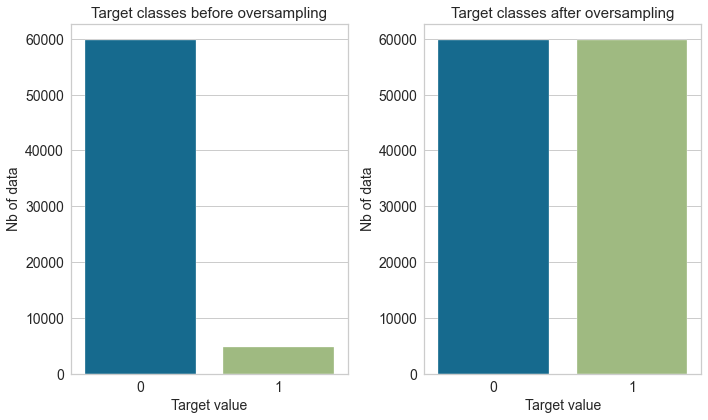

In [21]:
df_before = pd.DataFrame(target_train.value_counts())
df_before = df_before.T

df_after = pd.DataFrame(target_train_smote.value_counts())
df_after = df_after.T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), tight_layout=True)

sns.set_style("darkgrid")
sns.barplot(ax=ax1, data=df_before)
ax1.set_xlabel("Target value")
ax1.set_ylabel("Nb of data")
ax1.set_title("Target classes before oversampling")

sns.barplot(ax=ax2, data=df_after)
ax2.set_xlabel("Target value")
ax2.set_ylabel("Nb of data")
ax2.set_title("Target classes after oversampling");

In [22]:
print("TRANSFORMED + SMOTE DATA")
print("---------------------")
print("Train")
print(f"n rows: {data_train_smote.shape[0]}")
print(f"n columns: {data_train_smote.shape[1]}")
print("Test")
print(f"n rows: {data_test.shape[0]}")
print(f"n columns: {data_test.shape[1]}")

TRANSFORMED + SMOTE DATA
---------------------
Train
n rows: 119412
n columns: 229
Test
n rows: 16145
n columns: 229


## 3. Modeling

### 3.1. Functions

We set-up several functions to automatize model training, evaluation on test set, as well as grid-search with evaluation and cross-validation.

In [23]:
def train_eval_clf(estimator, data_train, target_train, data_test, target_test): 
    """
    Train, fit and predict a classification model on already splitted train and test data.
    Return metrics on train and test and classification report.

    estimator: model to fit

    data_train, target_train: df or array of train data and target

    data_test, target_test: df or array of test data and target
    """

    # Fit estimator
    t0 = time.time()
    estimator.fit(data_train, target_train)
    fit_time = time.time() - t0

    # Predict
    target_predicted_train = estimator.predict(data_train)
    target_predicted_test = estimator.predict(data_test)

    # Train metrics
    score_train = estimator.score(data_train, target_train)
    bal_accuracy_train = balanced_accuracy_score(target_train, target_predicted_train)
    recall_train = recall_score(target_train, target_predicted_train, zero_division=0)
    classif_report_train = classification_report(target_train, target_predicted_train, output_dict=True,
                                                    zero_division=0)
    roc_auc_train = roc_auc_score(target_train, target_predicted_train)
    f1_train = f1_score(target_train, target_predicted_train, zero_division=0)
    precision_train = precision_score(target_train, target_predicted_train, zero_division=0)

    # Test metrics
    score_test = estimator.score(data_test, target_test)
    bal_accuracy_test = balanced_accuracy_score(target_test, target_predicted_test)
    recall_test = recall_score(target_test, target_predicted_test, zero_division=0)
    classif_report_test = classification_report(target_test, target_predicted_test, output_dict=True,
                                                    zero_division=0)
    roc_auc_test = roc_auc_score(target_test, target_predicted_test)
    f1_test = f1_score(target_test, target_predicted_test, zero_division=0)
    precision_test = precision_score(target_test, target_predicted_test, zero_division=0)

    # Make dataframe with results
    estimator_name = str(estimator)
    metrics = pd.DataFrame({"estimator_name": [estimator_name],
                            "fit_time": [fit_time],
                            "train_score": [score_train],
                            "train_balanced_accuracy": [bal_accuracy_train], 
                            "train_recall": [recall_train],
                            "train_roc_auc": [roc_auc_train],
                            "train_precision": [precision_train],
                            "train_f1": [f1_train],
                            "test_score": [score_test],
                            "test_balanced_accuracy": [bal_accuracy_test], 
                            "test_recall": [recall_test],
                            "test_roc_auc": [roc_auc_test],
                            "test_precision": [precision_test],
                            "test_f1": [f1_test]
                            })
    classif_reports = {"classif_report_train": classif_report_train,
                        "classif_report_test": classif_report_test}

    return metrics, classif_reports

In [24]:
def multi_clf(estimators_list, data_train, target_train, data_test, target_test):
    """
    Train, fit and evaluate multiple classification models (on already splitted data),
    return a dataframe with train and test metrics.

    estimators_list: list of classification models
    
    data_train, target_train: df or array of train data and target

    data_test, target_test: df or array of test data and target

    """
    all_metrics = pd.DataFrame(columns=["estimator_name", "fit_time", "train_score", "train_balanced_accuracy",
                                        "train_recall", "train_roc_auc", "train_precision", "train_f1", "test_score",
                                        "test_balanced_accuracy", "test_recall", "test_roc_auc", "test_precision",
                                        "test_f1"])
    for estimator in estimators_list:
        print(f"********* Fitting {str(estimator)}... *********")
        metrics, _ = train_eval_clf(estimator, data_train, target_train, data_test, target_test)
        all_metrics = pd.concat([all_metrics, metrics])
    
    all_metrics = all_metrics.sort_values(by="test_roc_auc", ascending=False)

    return all_metrics

In [25]:
def get_all_scores(model_name, cv_results, scoring, train_score=False):
    
    """
    Create a Series containing metrics values from cross-validation output.
    Take in input the model name, the object containing the cross-validation results, 
    the list of metrics used in the CV and a boolean indicating if train scores were returned or not.
    Return a Series with fit time, score time and the mean of each metric defined in list_scores.
    
    model_name: str
        Model name that will be used to fill the first column of the final dataframe.
        
    cv_results:
        Output of a cross-validation.
    
    scoring: list of str
        List of metrics used in the cross-valisation.
    
    train_score: boolean
        Whether the cross-validation contains train scores or not. Default is False.
    
    """
    
    # Make a dataframe of the cross_validation results and set some variables
    cv_results = pd.DataFrame(cv_results)
    validation_scores = []
    train_scores = []
    n = len(scoring)
    
    # Add "test_" to the name of list of metrics
    for i in scoring:
        i = "test_" + i
        validation_scores.append(i)
    
    # Create a Series with basic info
    mean_results = pd.DataFrame([[model_name, cv_results["fit_time"].mean(), cv_results["score_time"].mean()]],
                             columns=["model_name", "fit_time", "score_time"])
    
    # If train score was return by cross_validation, create a list with appropriate names
    if train_score==True:
        for i in scoring:
            i = "train_" + i
            train_scores.append(i)
            
        # Add means for train metrics
        for i in range (0, n):
            mean_results[train_scores[i]] = cv_results[train_scores[i]].mean()
    
    # Add means for validation metrics
    for i in range (0, n):
            mean_results[validation_scores[i]] = cv_results[validation_scores[i]].mean()
    
    return mean_results

In [26]:
def custom_cv(estimator, name_model, data, target, scoring, n_splits=30):
    
    """
    Make a shuffle split followed by a cross-validation.
    Use the get_all_scores function to format the resulting metrics.
    Plot histograms of the mean AUC for train and test sets.
    Return the cross-validation results and Series with metrics.
    
    estimator:
        Estimator to use to fit and predict the target.
    
    name_model: str
        Name of the model that will be used in the Series returning the metrics of the cross-validation.
    
    data:
        Data that will be used in the cross-validation.
    
    target:
        Well... the target.
    
    scoring: list of str
        List of the metrics to use in the cross-validation.
    
    n_splits:
        Number of splits for the cross-validation (default is 30).
    
    """
    
    # Make suffle split and cross-validate
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)

    cv_results = cross_validate(estimator, data, target, cv=cv, n_jobs=-2, return_estimator=True, 
                                    return_train_score=True, scoring=scoring)
    
    # Format metrics output
    models_summary = get_all_scores(name_model, cv_results, scoring, train_score=True)
    
    cv_results_df = pd.DataFrame(cv_results)
    
    auc = cv_results_df[["train_roc_auc", "test_roc_auc"]]
    
    # Plot histograms of train vs. validation error
    fig, ax = plt.subplots(figsize=(5,5))

    sns.histplot(ax=ax, data=auc, legend=False)
    ax.legend(labels=["Validation", "Train"])
    ax.set_xlabel("AUC")
    ax.set_title("Train vs. Validation set\nDefault credit");
    
    return cv_results, models_summary

In [27]:
def logisticregression_cv(estimator, model_name, data_train, target_train, data_test, target_test):
    
    """
    To use when doing a logistic regression including a cross-validation (LogisticRegressionCV).
    Take in argument estimator, target, and data (already splitted in train and test).
    Display best C found and main metrics, plot of AUC vs. C and yellowbrick visualizations.
    Return evaluation results on the test set.
    Refit must be set to True in the estimator's arguments.
    When evaluating the model on the test set, will use the best parameters found.
    
    estimator:
        Estimator to be used in the modeling. Must specify parameters to test in the 
        estimator's arguments. Refit must be set to True.
        
    model_name: str
        Model name used in return scoring results.
    
    data_train, target_train, data_test, target_test:
        Data used to make the GridSearchCV (train data will be split into train and validation 
        sets for cross-validation incuded into the grid search).
    
    target_name: str
        Target name for display.
    
    """

    est = str(estimator)

    # Fit model:
    print("Fitting model...")
    estimator.fit(data_train, target_train)
        
    # Get best alpha and results of cross-validation:
    if "RidgeClassifierCV" in est:
        print(f"Ridge best alpha: {estimator.alpha_:.3f}")
        cv_results = estimator.cv_values_

        #errors = pd.DataFrame(cv_results)
        #errors.columns = list(alphas)
        #errors_alphas = errors.mean()
        #errors_alphas_std = errors.std()
            
    if "LogisticRegressionCV" in est:
            best_C = estimator.C_[0]
            best_l1_ratio = estimator.l1_ratio_[0]
            print(f"Logistic Regression best C: {best_C:.3f}")
            if best_l1_ratio is not None:
                print(f"Logistic Regression best l1 ratio: {best_l1_ratio:.3f}")
            
            # Get score vs. C Series:
            scores_C = pd.DataFrame(estimator.scores_[1], columns=estimator.Cs_).mean()

    else:
        print(f"Wrong estimator. Function for RidgeClassifierCV or LogisticRegressionCV only.")

    target_predicted_train = estimator.predict(data_train_smote)
    target_predicted_test = estimator.predict(data_test)
    
    # Get metrics on the train set:
    roc_auc_train = roc_auc_score(target_train_smote, target_predicted_train)
    accuracy_train = accuracy_score(target_train_smote, target_predicted_train)
    bal_accuracy_train = balanced_accuracy_score(target_train_smote, target_predicted_train)
    precision_train = precision_score(target_train_smote, target_predicted_train, zero_division=0)
    recall_train = recall_score(target_train_smote, target_predicted_train, zero_division=0)
    f1_train = f1_score(target_train_smote, target_predicted_train, zero_division=0)
        
    results_train = pd.DataFrame([[model_name, roc_auc_train, accuracy_train, 
                                    bal_accuracy_train, precision_train, 
                                    recall_train, f1_train]], 
                                    columns=["model_name",
                                            "train_roc_auc",
                                             "train_accuracy", 
                                             "train_balanced_accuracy", 
                                             "train_precision", 
                                             "train_recall",
                                             "train_f1"])

    # Get metrics on the test set:
    score_test = estimator.score(data_test, target_test)
    roc_auc_test = roc_auc_score(target_test, target_predicted_test)
    accuracy_test = accuracy_score(target_test, target_predicted_test)
    bal_accuracy_test = balanced_accuracy_score(target_test, target_predicted_test)
    precision_test = precision_score(target_test, target_predicted_test, zero_division=0)
    recall_test = recall_score(target_test, target_predicted_test, zero_division=0)
    f1_test = f1_score(target_test, target_predicted_test, zero_division=0)
        
    results_test = pd.DataFrame([[score_test, roc_auc_test, accuracy_test, bal_accuracy_test, precision_test, 
                                    recall_test, f1_test]], 
                                    columns=["test_score", 
                                            "test_roc_auc",
                                             "test_accuracy", 
                                             "test_balanced_accuracy", 
                                             "test_precision", 
                                             "test_recall",
                                             "test_f1"])

    results = pd.concat([results_train, results_test], axis=1)

    # Display a few test metrics: 
    print(f"Score : {score_test:.2f}")
    print(f"AUC : {roc_auc_test:.2e}")
    print(f"Balanced accuracy : {bal_accuracy_test:.2e}")
    print(f"Recall : {recall_test:.2e}")
    print("-----------------------------------------")

    
    # Plot errors vs. Cs or alphas:
    fig, ax = plt.subplots(2, 2, figsize=(14, 12), tight_layout=True)

    if "RidgeClassifierCV" in est:
        print("RidgeClassifier")
        # Plot alpha vs MSE
        #ax[0, 0].plot(errors_alphas, marker="+", color="steelblue")
        #ax[0, 0].semilogx()
        #ax[0, 0].set_ylabel(f"MSE pour target")
        #ax[0, 0].set_xlabel("Alpha")
        #ax[0, 0].set_title("MSE for tested alphas", pad=20)

    else:
        
        # Plot score vs. C:
        ax[0, 0].plot(scores_C, marker="+", color="steelblue")
        ax[0, 0].semilogx()
        ax[0, 0].set_ylabel(f"AUC")
        ax[0, 0].set_xlabel("C")
        ax[0, 0].set_title("AUC as a function of C", pad=20)

    # Display ROC-AUC curve 
    visualizer = ROCAUC(estimator, classes=[0, 1], ax=ax[0, 1])
    visualizer.fit(data_train, target_train)
    visualizer.score(data_test, target_test)
    visualizer.finalize()

    # Display Confusion matrix
    visualizer = ConfusionMatrix(estimator, classes=[0, 1], ax=ax[1, 0])
    visualizer.fit(data_train, target_train)
    visualizer.score(data_test, target_test)
    visualizer.finalize()

    # Display Classification report
    visualizer = ClassificationReport(estimator, classes=[0, 1], zero_division=0, support=True, ax=ax[1, 1])
    visualizer.fit(data_train, target_train)
    visualizer.score(data_test, target_test)
    visualizer.finalize()
        
    return results

In [28]:
def GS_eval_clf(estimator, model_name, data_train, target_train, data_test, target_test, refit, 
    n_splits=5, test_size=0.2, **params_GS):

    """
    Make a shuffle split, then a grid search including cross-validation (GridSearchCV), keep the best 
    hyperparameters and use them to predict the target on a separate dataset.
    Return train and test score and plot yellowbrick visualizations.
    
    estimator:
        Estimator to be used in the modeling (same for all targets).
        
    model_name: str
        Model name used in return scoring results.
    
    data_train:
        Data used to make the GridSearchCV (will be split into train and test sets for cross-validation incuded 
        into the grid search).
    
    target_train: 
        Target of train set.

    refit: str or callable
        Metric used to select the best model.
    
    data_test:
        Data used to predict the target with the best hyperparameters.
    
    target_test:
        Target of test set.
    
    n_splits: int
        Number of splits for the shuffle split procedure. Default is 10.
    
    test_size: int of float
        Test size of the shuffle split. Default is 0.2, meaning 20% of the data kept for grid search testing.
    
    **param_GS: dict
        Dict of other grid search CV parameters such as grid params, scorer...
    
    """
    
    # Make a grid search from a shuffle split
    print("Making Shuffle Split...")
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
    
    model_grid_search = GridSearchCV(estimator, cv=cv, refit=refit, return_train_score=True, **params_GS) 
        
    # Fit model and get best params
    print("Fitting GridSearchCV start...")
    model_grid_search.fit(data_train, target_train)

    print(f"Best params: {model_grid_search.best_params_}")

    # Modify metrics names to retrieve cross-validation results from output
    train_scores = ["mean_fit_time", "mean_score_time"]
    # Test if scoring is home-made callable
    if type(scoring) is str or list:
        for score in scoring:
            score = "mean_train_" + score
            train_scores.append(score)
    else:
        train_scores.append("mean_train_score")
    # Test if refit is str or callable
    if type(refit) is str:
        rank_refit = "rank_test_" + refit
    else:
        rank_refit = "rank_test_score"
    model_name_df = pd.DataFrame([model_name], columns=["model_name"])
    
    # Get train scores for all metrics
    cv_results = pd.DataFrame(model_grid_search.cv_results_)
    best_model_results = cv_results[rank_refit]==1
    train_results = cv_results[best_model_results][train_scores]
    train_results.reset_index(inplace=True)
    
    # Use model with best params to evaluate it on a separate test set
    target_predicted = model_grid_search.predict(data_test)
    
    # Get metrics on the test set
    score_test = model_grid_search.score(data_test, target_test)
    roc_auc = roc_auc_score(target_test, target_predicted)
    accuracy_test = accuracy_score(target_test, target_predicted)
    bal_accuracy_test = balanced_accuracy_score(target_test, target_predicted)
    precision_test = precision_score(target_test, target_predicted, zero_division=0)
    recall_test = recall_score(target_test, target_predicted, zero_division=0)
    f1_test = f1_score(target_test, target_predicted, zero_division=0)
    
    # Make a dataframe containing train and test metrics
    test_results = pd.DataFrame([[score_test, roc_auc, accuracy_test, bal_accuracy_test, precision_test, 
                                recall_test, f1_test]], 
                                columns=["test_score", 
                                        "test_roc_auc",
                                        "test_accuracy", 
                                        "test_balanced_accuracy", 
                                        "test_precision", 
                                        "test_recall",
                                        "test_f1"])
    results = pd.concat([model_name_df, train_results, test_results], axis=1)
    results.drop("index", axis=1, inplace=True)
    results.rename(columns={"mean_fit_time":"fit_time",
                            "mean_score_time":"score_time",
                            "mean_train_accuracy":"train_accuracy",
                            "mean_train_balanced_accuracy":"train_balanced_accuracy",
                            "mean_train_roc_auc":"train_roc_auc", 
                            "mean_train_recall":"train_recall",
                            "mean_train_precision":"train_precision",
                            "mean_train_f1":"train_f1"},
                            inplace=True)

    # Display a few test metrics
    print(f"Score : {score_test:.2f}")
    print(f"AUC : {roc_auc:.2e}")
    print(f"Balanced accuracy : {bal_accuracy_test:.2e}")
    print(f"Recall : {recall_test:.2e}")
    print("-----------------------------------------")

    # Get estimator name
    est = str(estimator)
    # If Linear SVC, plot ROC-AUC curve with sklearn
    if "LinearSVC" in est:
        plot_roc_curve(model_grid_search, data_test, target_test)
    else:
        # Else plot with yellowbrick
        fig, ax = plt.subplots(figsize=(7, 6))
        visualizer = ROCAUC(model_grid_search, classes=[0, 1])
        visualizer.fit(data_train, target_train)
        visualizer.score(data_test, target_test)
        visualizer.finalize()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
    # Display Confusion matrix
    visualizer = ConfusionMatrix(model_grid_search, classes=[0, 1], ax=ax1)
    visualizer.fit(data_train, target_train)
    visualizer.score(data_test, target_test)
    visualizer.finalize()

    # Display Classification report
    visualizer = ClassificationReport(model_grid_search, classes=[0, 1], zero_division=0, support=True, ax=ax2)
    visualizer.fit(data_train, target_train)
    visualizer.score(data_test, target_test)
    visualizer.finalize()
    
    return results, cv_results

In [29]:
scoring = ["accuracy", "balanced_accuracy", "roc_auc", "recall", "precision", "f1"]

### 3.2. Testing models with default parameters

We will make a quick test of several common models with default parameters.

We use the classic ROC AUC as our main metric, but also compute recall, precision, F1 score, accuracy and balanced accuracy.

We do not use neural networks given our problematic: the model need a good explainability to be used by insurers who must be able to justify their decision of giving or refusing loans to clients.

In [30]:
models = [DummyClassifier(strategy="constant", constant=0),
        LogisticRegression(max_iter=1000, n_jobs=-2),
        LinearSVC(dual=False),
        SGDClassifier(n_jobs=-2), 
        RandomForestClassifier(n_jobs=-2),
        LGBMClassifier(n_jobs=-2)]

In [31]:
raw_models = multi_clf(models, data_train_smote, target_train_smote, data_test, target_test)

********* Fitting DummyClassifier(constant=0, strategy='constant')... *********
********* Fitting LogisticRegression(max_iter=1000, n_jobs=-2)... *********
********* Fitting LinearSVC(dual=False)... *********
********* Fitting SGDClassifier(n_jobs=-2)... *********
********* Fitting RandomForestClassifier(n_jobs=-2)... *********
********* Fitting LGBMClassifier(n_jobs=-2)... *********


In [32]:
raw_models

estimator_name  fit_time  train_score  \
0      LogisticRegression(max_iter=1000, n_jobs=-2) 372.57772      0.73284   
0                             LinearSVC(dual=False)  46.86956      0.73251   
0                          SGDClassifier(n_jobs=-2)   3.74789      0.72908   
0                         LGBMClassifier(n_jobs=-2)   3.28713      0.96053   
0                 RandomForestClassifier(n_jobs=-2)  21.56899      1.00000   
0  DummyClassifier(constant=0, strategy='constant')   0.00499      0.50000   

   train_balanced_accuracy  train_recall  train_roc_auc  train_precision  \
0                  0.73284       0.75070        0.73284          0.72481   
0                  0.73251       0.75394        0.73251          0.72296   
0                  0.72908       0.75054        0.72908          0.71965   
0                  0.96053       0.92173        0.96053          0.99927   
0                  1.00000       1.00000        1.00000          1.00000   
0                  0.50000       0.00000        0.50000          0.00000   

   train_f1  test_score  test_balanced_accuracy  test_recall  test_roc_auc  \
0   0.73753     0.71644                 0.68702      0.65246       0.68702   
0   0.73813     0.71242                 0.68638      0.65581       0.68638   
0   0.73477     0.70610                 0.68297      0.65581       0.68297   
0   0.95894     0.92598                 0.51236      0.02673       0.51236   
0   1.00000     0.92555                 0.50022      0.00084       0.50022   
0   0.00000     0.92586                 0.50000      0.00000       0.50000   

   test_precision  test_f1  
0         0.15800  0.25440  
0         0.15650  0.25270  
0         0.15338  0.24861  
0         0.51613  0.05083  
0         0.14286  0.00166  
0         0.00000  0.00000

Linear models with default parameters perform significantly better than ensemble models. As expected, the dummy classifier is the worst model.

There are large differences in fit time, with linear regression being the slowest model, followed by linear SVC and random forest. SGD classifier and LGBM classifier are performing much better from this point of view.

### 3.3. Logistic regression

We will test various logistic regression parameters: penalty value (C) and solver used. Note that the saga solver do not converge on these data, which preclude the use of Elastic Net regularization. Sag solver also has some convergence problems. We will therefore focus on L1 and L2 penalty with the other solvers.

3.3.1. GridSearch for best Cs and solvers with L2 penalty

In [33]:
model_lr = LogisticRegression(penalty="l2", max_iter=2000, n_jobs=-2, random_state=42)

In [34]:
params_lr = {"scoring": scoring,
            "n_jobs": -2,
            "param_grid": {"C": np.logspace(-4, 4, 9),
                            "solver": ["newton-cg", "lbfgs", "liblinear", "sag"]}
            }

In [35]:
# /!\ 12h15 of grid search.
# Uncomment if you want to run cell.
# Else, results stored in csv will be loaded.

#best_results_lr_l2, cv_results_lr_l2 = GS_eval_clf(model_lr, "Logistic Regression L2", data_train_smote, target_train_smote, 
#    data_test, target_test, refit="roc_auc", **params_lr)

The model makes about 76% of correct prediction, with 65% of clients making default correctly predicted (recall=0.652). The AUC is 0.687.

In [36]:
# Results summarized for all folds
best_results_lr_l2

model_name   fit_time  score_time  train_accuracy  \
0  Logistic Regression L2 1214.55474     0.09114         0.73379   

   train_balanced_accuracy  train_roc_auc  train_recall  train_precision  \
0                  0.73380        0.80621       0.75061          0.72596   

   train_f1  test_score  test_roc_auc  test_accuracy  test_balanced_accuracy  \
0   0.73808     0.75773       0.68733        0.71775                 0.68733   

   test_precision  test_recall  test_f1  
0         0.15854      0.65163  0.25503

In [37]:
# Detail of cross-validation folds
cv_results_lr_l2.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        8.33611       0.50935          0.08035         0.01100  0.00010   
1        1.51636       0.24410          0.07675         0.01046  0.00010   
2        2.00089       0.11088          0.06465         0.00467  0.00010   
3       26.26457       1.15299          0.06575         0.01562  0.00010   
4        8.37680       1.79901          0.06972         0.01690  0.00100   

  param_solver                                params  split0_test_accuracy  \
0    newton-cg  {'C': 0.0001, 'solver': 'newton-cg'}               0.72131   
1        lbfgs      {'C': 0.0001, 'solver': 'lbfgs'}               0.72131   
2    liblinear  {'C': 0.0001, 'solver': 'liblinear'}               0.71968   
3          sag        {'C': 0.0001, 'solver': 'sag'}               0.72131   
4    newton-cg   {'C': 0.001, 'solver': 'newton-cg'}               0.72734   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0               0.72005               0.72122               0.72340   
1               0.72009               0.72122               0.72340   
2               0.71976               0.71942               0.72332   
3               0.72014               0.72114               0.72336   
4               0.72855               0.72838               0.73245   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0               0.72051             0.72130            0.00115   
1               0.72051             0.72131            0.00114   
2               0.72047             0.72053            0.00144   
3               0.72051             0.72129            0.00112   
4               0.73085             0.72951            0.00186   

   rank_test_accuracy  split0_train_accuracy  split1_train_accuracy  \
0                  34                0.72176                0.72186   
1                  33                0.72176                0.72188   
2                  36                0.72133                0.72117   
3                  35                0.72179                0.72185   
4                  29                0.73106                0.73061   

   split2_train_accuracy  split3_train_accuracy  split4_train_accuracy  \
0                0.72136                0.72131                0.72186   
1                0.72136                0.72133                0.72186   
2                0.72103                0.72108                0.72171   
3                0.72137                0.72134                0.72190   
4                0.73028                0.72935                0.73039   

   mean_train_accuracy  std_train_accuracy  split0_test_balanced_accuracy  \
0              0.72163             0.00025                        0.72132   
1              0.72164             0.00024                        0.72132   
2              0.72126             0.00024                        0.71970   
3              0.72165             0.00024                        0.72132   
4              0.73034             0.00056                        0.72735   

   split1_test_balanced_accuracy  split2_test_balanced_accuracy  \
0                        0.72004                        0.72106   
1                        0.72008                        0.72106   
2                        0.71973                        0.71907   
3                        0.72013                        0.72098   
4                        0.72854                        0.72820   

   split3_test_balanced_accuracy  split4_test_balanced_accuracy  \
0                        0.72347                        0.72044   
1                        0.72347                        0.72044   
2                        0.72348                        0.72029   
3                        0.72343                        0.72044   
4                        0.73253                        0.73075   

   mean_test_balanced_accuracy  std_test_balanced_accuracy  \
0                      0.72127                    

3.3.2. Cross-validation with best l2 model

We will make a cross-validation of our best model.

In [38]:
model_lr = LogisticRegression(penalty="l2", solver="newton-cg", C=100, max_iter=2000, n_jobs=-2, random_state=42)

In [39]:
# /!\ 4h30 to run this cell
# Uncomment if you want to run cell.
# Else, results stored in csv will be loaded.

#cv_results_lr_newton_cg, models_summary_lr_newton_cg = custom_cv(model_lr, "Logistic regression L2 newton-cg C=100", data_train_smote, 
                                                        #target_train_smote, scoring)

In [40]:
#models_summary_lr_newton_cg

In [41]:
model_lr = LogisticRegression(penalty="l2", solver="lbfgs", C=100, max_iter=2000, n_jobs=-2, random_state=42)

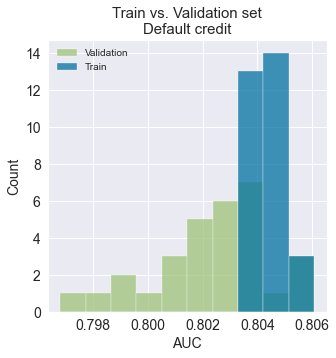

In [42]:
# 8 min 30s
cv_results_lr_lbfgs, models_summary_lr_lbfgs = custom_cv(model_lr, "Logistic regression L2 lbfgs C=100", data_train_smote, 
                                                        target_train_smote, scoring)

In [43]:
models_summary_lr_lbfgs

model_name  fit_time  score_time  train_accuracy  \
0  Logistic regression L2 lbfgs C=100  48.03619     0.06672         0.73270   

   train_balanced_accuracy  train_roc_auc  train_recall  train_precision  \
0                  0.73270        0.80431       0.75041          0.72471   

   train_f1  test_accuracy  test_balanced_accuracy  test_roc_auc  test_recall  \
0   0.73734        0.73165                 0.73164       0.80239      0.74968   

   test_precision  test_f1  
0         0.72370  0.73645

The train and validation scores overlap, we are therefore in a correct range.

3.3.3. GridSearch for best C with L1 penalty

Same type of search as before, for L1 penalty (only liblinear solver since the others available with L1 do not converge).

In [44]:
model_lr = LogisticRegressionCV(penalty="l1", solver="liblinear", scoring="roc_auc", refit=True,
                                max_iter=2000, n_jobs=-2, random_state=42)

Fitting model...
Logistic Regression best C: 21.544
Score : 0.76
AUC : 6.87e-01
Balanced accuracy : 6.87e-01
Recall : 6.52e-01
-----------------------------------------


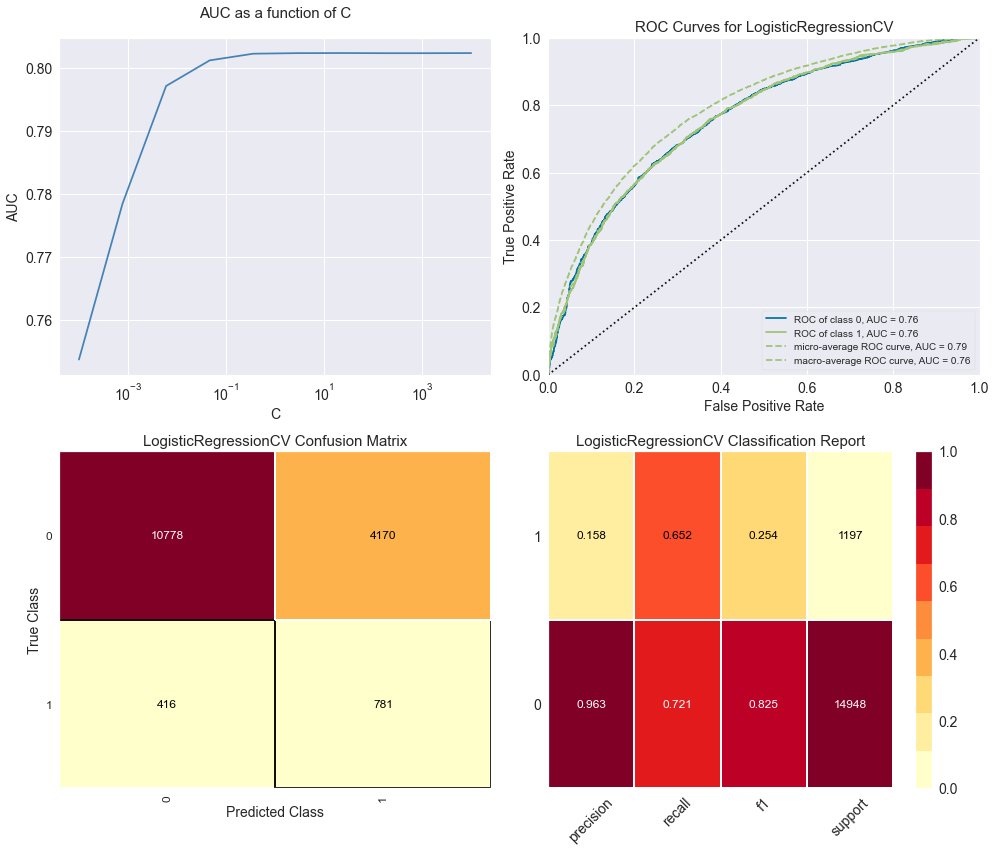

In [45]:
# 9 min
best_results_lr_l1 = logisticregression_cv(model_lr, "Logistic Regression L1", 
    data_train_smote, target_train_smote,
    data_test, target_test)

In [46]:
best_results_lr_l1

model_name  train_roc_auc  train_accuracy  \
0  Logistic Regression L1        0.73284         0.73284   

   train_balanced_accuracy  train_precision  train_recall  train_f1  \
0                  0.73284          0.72486       0.75059   0.73750   

   test_score  test_roc_auc  test_accuracy  test_balanced_accuracy  \
0     0.75849       0.68675        0.71595                 0.68675   

   test_precision  test_recall  test_f1  
0         0.15775      0.65246  0.25407

The results for L1 linear regression with liblinear solver are also good, but slightly lower than with L2 regularization (0.685 AUC when it was 0.687 for L2).

3.3.4. Cross-validation with best L1 model

In [47]:
model_lr = LogisticRegression(penalty="l1", solver="liblinear", C=21, max_iter=2000, n_jobs=-2, random_state=42)

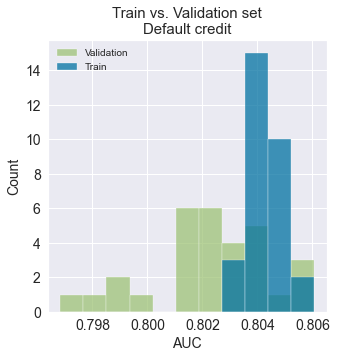

In [48]:
# 5 min
cv_results_lr_liblinear, models_summary_lr_liblinear = custom_cv(model_lr, "Logistic regression L1 liblinear", data_train_smote, 
                                                        target_train_smote, scoring)

In [49]:
models_summary_lr_liblinear

model_name  fit_time  score_time  train_accuracy  \
0  Logistic regression L1 liblinear  16.05531     0.06969         0.73271   

   train_balanced_accuracy  train_roc_auc  train_recall  train_precision  \
0                  0.73271        0.80431       0.75043          0.72471   

   train_f1  test_accuracy  test_balanced_accuracy  test_roc_auc  test_recall  \
0   0.73734        0.73167                 0.73167       0.80240      0.74971   

   test_precision  test_f1  
0         0.72373  0.73648

As for L1 penalty, we have similar train and validation scores.

### 3.4. Linear SVC

In [50]:
model_lsvc = LinearSVC(max_iter=3000, dual=False, random_state=0)

In [51]:
params_lsvc = {"scoring": scoring,
                "n_jobs": -2,
                "param_grid": {"C": [0.01, 0.1, 1, 10, 100]}
                }

Making Shuffle Split...
Fitting GridSearchCV start...
Best params: {'C': 0.1}
Score : 0.76
AUC : 6.87e-01
Balanced accuracy : 6.87e-01
Recall : 6.57e-01
-----------------------------------------


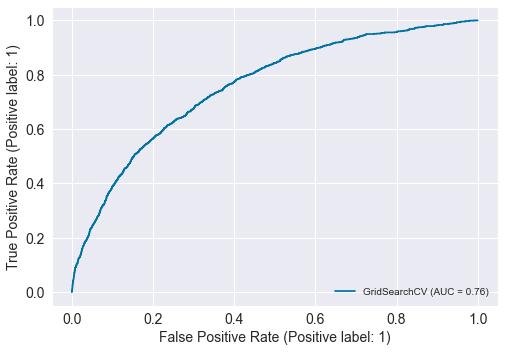

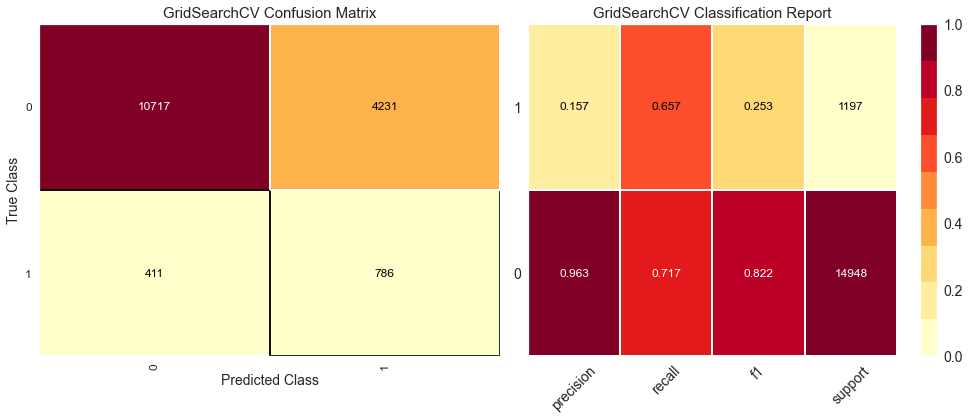

In [52]:
# 10 min
best_results_lsvc, cv_results_gs_lsvc = GS_eval_clf(model_lsvc, "Linear SVC L2", 
                                            data_train_smote, target_train_smote, 
                                            data_test, target_test,
                                            refit="roc_auc", **params_lsvc)

In [53]:
best_results_lsvc

model_name  fit_time  score_time  train_accuracy  \
0  Linear SVC L2  45.57256     0.06203         0.73262   

   train_balanced_accuracy  train_roc_auc  train_recall  train_precision  \
0                  0.73263        0.80439       0.75375          0.72296   

   train_f1  test_score  test_roc_auc  test_accuracy  test_balanced_accuracy  \
0   0.73803     0.75842       0.68680        0.71248                 0.68680   

   test_precision  test_recall  test_f1  
0         0.15667      0.65664  0.25298

LinearSVC has good results, close to linear regression, but still slightly lower (AUC=0.686, when it is 0.687 for linear regression).

Let's make a cross-validation of this model.

In [54]:
best_model_lsvc = LinearSVC(max_iter=3000, penalty="l2", C=10, dual=False, random_state=0)

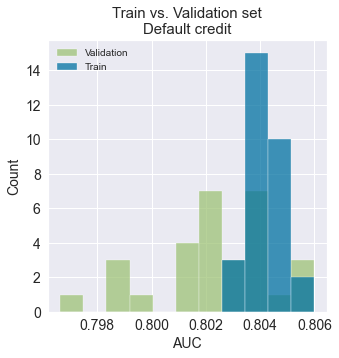

In [55]:
# 15min
cv_results_lsvc, models_summary_lsvc = custom_cv(best_model_lsvc, "Linear SVC L2", data_train_smote, 
                                                        target_train_smote, scoring)

Train and validation scores are in the same range.

### 3.4. Random Forest

#### 3.4.1. GridSearch and cross-validation

Now we test a Random Forest model with a grid search and a cross-validation with the best parameters found. Note that a larger range of parameters has been previously tested (not presented here to lower computation time of the notebook). Here we only try to refine the most important parameters.

In [56]:
# We fix max_depth to avoid overfitting
model_rf = RandomForestClassifier(max_depth=8, n_jobs=-2, random_state=42)

In [57]:
# Fine tuning of the most important hyperparameters
params_rf = {"scoring": scoring,
            "n_jobs": -2,
            "param_grid": {"n_estimators": [125, 150, 175],
                            "max_features": [0.25, 0.3, 0.35],
                            "min_impurity_decrease": [0.015, 0.02, 0.025]}
            }

In [58]:
# /!\ 1h to run this cell
# Uncomment if you want to run cell.
# Else, results stored in csv will be loaded.

#best_results_rf, cv_results_gs_rf = GS_eval_clf(model_rf, "Random Forest", data_train_smote, target_train_smote, data_test, target_test, 
#    refit="roc_auc", **params_rf)

The ROC AUC is significantly lower than with logistic regression, as suggested by the first tests wedid with default prameters. Even optimization of hyperparameters do not reduce the gap in test scores.

In [59]:
best_results_rf

model_name  fit_time  score_time  train_accuracy  \
0  Random Forest  82.13728     1.89703         0.81623   

   train_balanced_accuracy  train_roc_auc  train_recall  train_precision  \
0                  0.81621        0.89324       0.80933          0.82062   

   train_f1  test_score  test_roc_auc  test_accuracy  test_balanced_accuracy  \
0   0.81486     0.66104       0.61607        0.79498                 0.61607   

   test_precision  test_recall  test_f1  
0         0.15754      0.40602  0.22700

In [60]:
best_model_rf = RandomForestClassifier(max_depth=8, max_features=0.25, n_estimators=175,
    min_impurity_decrease=0.015, n_jobs=-2, random_state=42)

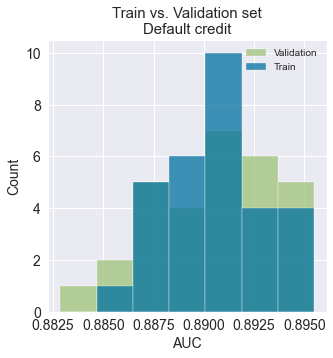

In [61]:
# 14 min
cv_results_rf, models_summary_rf = custom_cv(best_model_rf, "Random Forest", data_train_smote, 
                                                        target_train_smote, scoring)

In [62]:
models_summary_rf

model_name  fit_time  score_time  train_accuracy  \
0  Random Forest  74.55326     0.73334         0.81379   

   train_balanced_accuracy  train_roc_auc  train_recall  train_precision  \
0                  0.81379        0.89059       0.80831          0.81734   

   train_f1  test_accuracy  test_balanced_accuracy  test_roc_auc  test_recall  \
0   0.81276        0.81336                 0.81336       0.89033      0.80838   

   test_precision  test_f1  
0         0.81671  0.81248

The cross-validation show a slight difference between train and validation, and a large gap with test scores, so quite a lot of overfitting. Random Forest model do not seem adapted to our data and problem. Logistic regression still has the best results so far.

#### 3.4.2. Feature importance of Random Forest

We look at the most important features in our best random forest model.

In [63]:
model_rf = RandomForestClassifier(max_depth=8, max_features=0.25, n_estimators=175, min_impurity_decrease=0.015, 
    n_jobs=-2, random_state=42)

In [64]:
model_rf.fit(data_train_smote, target_train_smote)

RandomForestClassifier(max_depth=8, max_features=0.25,
                       min_impurity_decrease=0.015, n_estimators=175, n_jobs=-2,
                       random_state=42)

In [65]:
# Plot
x, y = (list(x) for x in zip(*sorted(zip(model_rf.feature_importances_, new_features_names), reverse = False)))
trace = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
     yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True)
)

fig1 = go.Figure(data=[trace])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

Features related to education, income type, profession, and external sources seem the are important features. Surprisingly, total income and annuity are considered the least important features for Random forest.

### 3.5. LightGBM

Since LightGBM was widely used in the Kaggle competition, we will also give a try (although linear models seem to perform better up to now). Same as for Random forest, the grid search presented here is focused on a small range for each parameters (fine tuning). Larger range grid search was performed before hand.

In [66]:
model_lgbm = LGBMClassifier(objective="binary", n_estimators=10000, 
                            num_leaves=36, 
                            n_jobs=-2, random_state=42)

In [67]:
params_lgbm = {"scoring": scoring,
            "n_jobs": -2,
            "param_grid": {"learning_rate": [0.8, 0.9, 1],
                            "colsample_bytree": [0.8, 0.9],
                            "reg_alpha": [0.03, 0.04, 0.05]}
            }

In [68]:
# /!\ 1h25min
# Uncomment to run this cell.
# Else, results will be loaded from csv

#best_results_lgbm, cv_results_lgbm = GS_eval_clf(model_lgbm, "LightGBM", data_train_smote, target_train_smote, data_test, target_test, 
#    refit="roc_auc", **params_lgbm)

In [69]:
best_results_lgbm

model_name  fit_time  score_time  train_accuracy  train_balanced_accuracy  \
0   LightGBM 146.14972     1.35698         0.84816                  0.84813   

   train_roc_auc  train_recall  train_precision  train_f1  test_score  \
0        0.84815       0.84241          0.85276   0.84661     0.54792   

   test_roc_auc  test_accuracy  test_balanced_accuracy  test_precision  \
0       0.54797        0.75924                 0.54797         0.10534   

   test_recall  test_f1  
0      0.29992  0.15592

The mean AUC on the test set being 0.56, this model performs even worst than the Random Forest, and we will not push the exploration further.

### 3.6. Results

We can now make a dtaframe of the models results.

In [70]:
results = pd.concat([best_results_lr_l2,
                    best_results_lr_l1,
                    best_results_lsvc,
                    best_results_rf,
                    best_results_lgbm])

results.sort_values(by="test_roc_auc", ascending=False, inplace=True)
results = results.reset_index()
results.drop("index", axis=1, inplace=True)

In [71]:
# Add fit time and score time for L1 logistic regression (no output by LogisticRegressionCV)
model_lr = LogisticRegression(penalty="l1", solver="liblinear", C=21,
                                max_iter=2000, n_jobs=-2, random_state=42)
t0 = time.time()
model_lr.fit(data_train_smote, target_train_smote)
t1 = time.time()
score_test = model_lr.score(data_test, target_test)
t2 = time.time()
fit_time = t1-t0
score_time = t2-t1

results.loc[1, "fit_time"] = fit_time
results.loc[1, "score_time"] = score_time

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.


In [72]:
results

model_name   fit_time  score_time  train_accuracy  \
0  Logistic Regression L2 1214.55474     0.09114         0.73379   
1           Linear SVC L2    5.87754     0.00862         0.73262   
2  Logistic Regression L1        NaN         NaN         0.73284   
3           Random Forest   82.13728     1.89703         0.81623   
4                LightGBM  146.14972     1.35698         0.84816   

   train_balanced_accuracy  train_roc_auc  train_recall  train_precision  \
0                  0.73380        0.80621       0.75061          0.72596   
1                  0.73263        0.80439       0.75375          0.72296   
2                  0.73284        0.73284       0.75059          0.72486   
3                  0.81621        0.89324       0.80933          0.82062   
4                  0.84813        0.84815       0.84241          0.85276   

   train_f1  test_score  test_roc_auc  test_accuracy  test_balanced_accuracy  \
0   0.73808     0.75773       0.68733        0.71775                 0.68733   
1   0.73803     0.75842       0.68680        0.71248                 0.68680   
2   0.73750     0.75849       0.68675        0.71595                 0.68675   
3   0.81486     0.66104       0.61607        0.79498                 0.61607   
4   0.84661     0.54792       0.54797        0.75924                 0.54797   

   test_precision  test_recall  test_f1  
0         0.15854      0.65163  0.25503  
1         0.15667      0.65664  0.25298  
2         0.15775      0.65246  0.25407  
3         0.15754      0.40602  0.22700  
4         0.10534      0.29992  0.15592

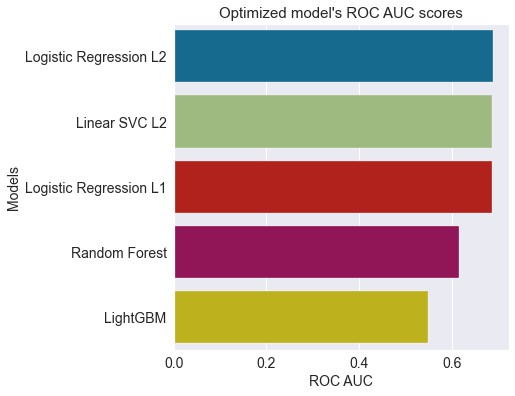

In [73]:
fig, ax = plt.subplots(figsize=(6,6))

sns.barplot(ax=ax, orient="h", y=results.model_name, x=results.test_roc_auc)
ax.set_title("Optimized model's ROC AUC scores")
ax.set_xlabel("ROC AUC")
ax.set_ylabel("Models");

The best result is given by L2 logistic regression with newton-cg solver and C=100 that gives 0.687 ROC AUC on the test set.

## 4. Creation of cost function

To better evaluate the models, we will build a cost function taking into account gains and losses (coefficients) multipled by the number of clients for each case of the confusion matrix.
The following gains and losses will be taken into account:

![table](./confusion_costs.png)

Our cost function will be the total revenue of a model such as:

R = (mean interests) * TN - (mean interests) * FP - (mean debt default loans + mean debt interests) * FN

In [74]:
# Calculate the % of credit not repaid after default
mean_debt = bureau["AMT_CREDIT_SUM_DEBT"].mean()
mean_credit = bureau["AMT_CREDIT_SUM"].mean()
perc_debt = mean_debt/mean_credit * 100
print(f"People are generally indebt of {perc_debt:.1f} % of their credit.")

People are generally indebt of 38.6 % of their credit.


In [75]:
# Calculate mean credit for clients making default ant the others
mean_credit_default = app_train[app_train["TARGET"]==1]["AMT_CREDIT"].mean()
mean_credit_repaid = app_train[app_train["TARGET"]==0]["AMT_CREDIT"].mean()
print(f"Mean credit of client who repay their loans: {mean_credit_repaid:.0f} $.")
print(f"Mean credit of client who make default: {mean_credit_default:.0f} $.")

Mean credit of client who repay their loans: 602648 $.
Mean credit of client who make default: 557779 $.


We can now calculate the mean loan debt in dollars.

In [76]:
mean_debt = perc_debt * mean_credit_default /100
print(f"Mean debt: {mean_debt:.0f} $.")

Mean debt: 215392 $.


Having a look at interests for repaid and default loans.

In [77]:
interest_primary_default = app_prev_train[app_prev_train["TARGET"]==1]["RATE_INTEREST_PRIMARY"].mean()
interest_primary_repaid = app_prev_train[app_prev_train["TARGET"]==0]["RATE_INTEREST_PRIMARY"].mean()

interest_privileged_default = app_prev_train[app_prev_train["TARGET"]==1]["RATE_INTEREST_PRIVILEGED"].mean()
interest_privileged_repaid = app_prev_train[app_prev_train["TARGET"]==0]["RATE_INTEREST_PRIVILEGED"].mean()

interests = pd.DataFrame({"Primary interests": [interest_primary_repaid, interest_primary_default],
                            "Privileged interests": [interest_privileged_repaid, interest_privileged_default]},
                            index=["0 (default)", "1 (repaid)"])
interests

Primary interests  Privileged interests
0 (default)            0.18948               0.77043
1 (repaid)             0.18899               0.78097

There is a large difference between primary and privileged interests, but not significant between repaid and non repaid loan. We will use the mean interest rate of all categories and targets.

The interests rate seem pretty low (< 1%). We will check with other sources of informations on USA credit mean interest rates.

Mean interest rate USA in 2018 were 4.904 % (Source: https://data.worldbank.org/indicator/FR.INR.LEND?end=2020&locations=US&start=1960)

So we obviously need to multiply the dataframe values by 10 to have something coherent.

In [78]:
mean_interest = pd.concat([previous_app["RATE_INTEREST_PRIMARY"], previous_app["RATE_INTEREST_PRIVILEGED"]]).mean()*10
print(f"The mean interest rate is {mean_interest:.2f} %.")

The mean interest rate is 4.81 %.


We have all we need to calculate our coefficients.

In [79]:
# Interests for TN and TP
mean_interest_repaid = mean_interest * mean_credit_repaid / 100
mean_interest_default = mean_interest * mean_credit_default / 100

# Debts for FN
mean_debt_loan = perc_debt * mean_credit_default / 100
mean_debt_interest = perc_debt * mean_interest_default / 100
total_debt = mean_debt_loan + mean_debt_interest

In [80]:
print(f"Mean interest for repaid loans: {mean_interest_repaid:.0f} $.")
print(f"Mean total debt for default loans: {total_debt:.0f} $.")

Mean interest for repaid loans: 28983 $.
Mean total debt for default loans: 225751 $.


Our coefficients will therefore be:

![table](./confusion_costs_coefs.png)

With cost function such as:

R = TN * 28983 - FP * 28983 - FN * 216428

In [81]:
# Making our cost function
def score_loans(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    score = confusion[0][0] * 28983 - confusion[1][0] * 28983 - confusion[0][1] * 216428
    return score

score_function = make_scorer(score_loans)

## 5. Modeling with home-made cost function

We use our home-made cost function to tune again the hyperparameters for our logistic regression.

### 5.1. L1 liblinear

In [82]:
model_lr = LogisticRegressionCV(penalty="l1", solver="liblinear", scoring=score_function, refit=True, 
                                max_iter=2000, n_jobs=-2, random_state=42)

Fitting model...
Logistic Regression best C: 2.783
Score : -601417698.00
AUC : 6.87e-01
Balanced accuracy : 6.87e-01
Recall : 6.53e-01
-----------------------------------------


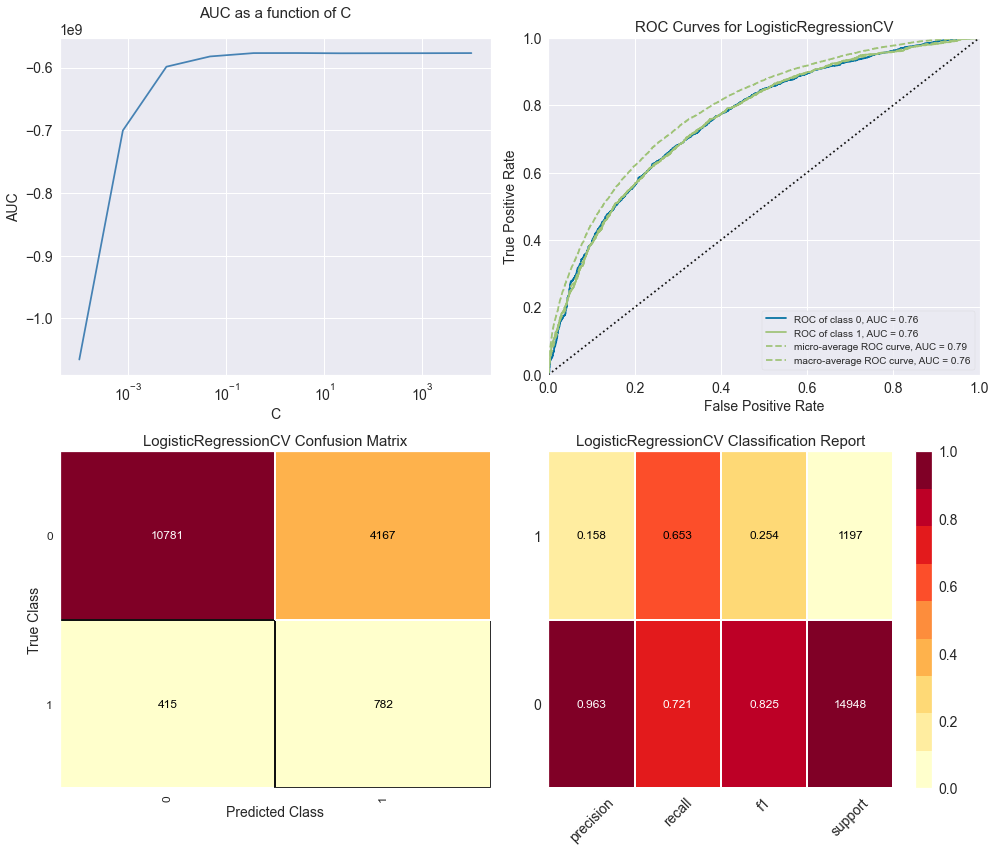

In [83]:
# 7 min
results_lr_myscore_l1 = logisticregression_cv(model_lr, "Logistic Regression MyScore l1 liblinear", 
    data_train_smote, target_train_smote, data_test, target_test)

In [84]:
results_lr_myscore_l1

model_name  train_roc_auc  train_accuracy  \
0  Logistic Regression MyScore l1 liblinear        0.73284         0.73284   

   train_balanced_accuracy  train_precision  train_recall  train_f1  \
0                  0.73284          0.72486       0.75058   0.73750   

   test_score  test_roc_auc  test_accuracy  test_balanced_accuracy  \
0  -601417698       0.68727        0.71620                 0.68727   

   test_precision  test_recall  test_f1  
0         0.15801      0.65330  0.25447

### 5.2. L2 lbfgs

In [85]:
model_lr = LogisticRegressionCV(penalty="l2", solver="lbfgs", scoring=score_function, refit=True, 
                                max_iter=2000, n_jobs=-2, random_state=42)

Fitting model...
Logistic Regression best C: 2.783
Score : -601446681.00
AUC : 6.87e-01
Balanced accuracy : 6.87e-01
Recall : 6.52e-01
-----------------------------------------


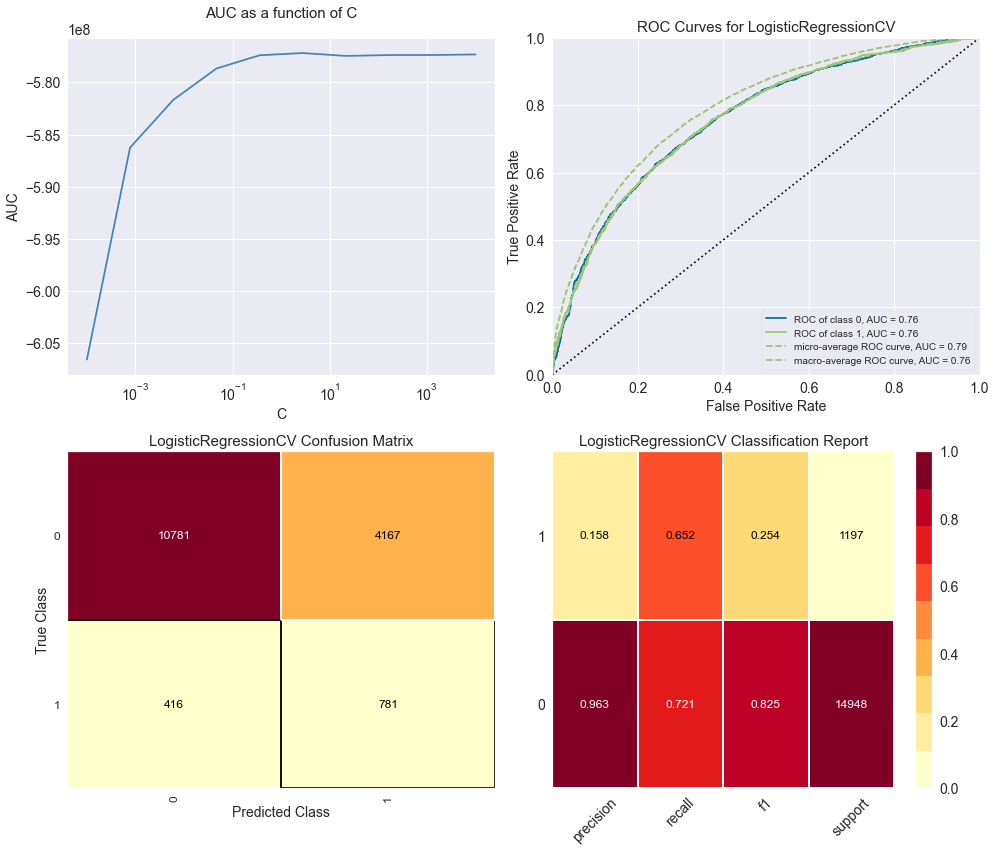

In [86]:
# 3 min
results_lr_myscore_l2 = logisticregression_cv(model_lr, "Logistic Regression MyScore l2 lbfgs", 
    data_train_smote, target_train_smote, data_test, target_test)

In [87]:
results_lr_myscore_l2

model_name  train_roc_auc  train_accuracy  \
0  Logistic Regression MyScore l2 lbfgs        0.73287         0.73287   

   train_balanced_accuracy  train_precision  train_recall  train_f1  \
0                  0.73287          0.72485       0.75071   0.73756   

   test_score  test_roc_auc  test_accuracy  test_balanced_accuracy  \
0  -601446681       0.68685        0.71614                 0.68685   

   test_precision  test_recall  test_f1  
0         0.15784      0.65246  0.25419

The L2 logistic regression with lbfgs solver and C=21.544 gives the best results for our specific cost function.

## 6. Features importance

### 6.1. Global

We will have a look at the logistic regression coefficients to see what are the features that matter the most in the model prediction. Here, we select the top 70 features with the strongest (positive or negative) coefficients.

In [88]:
def format_importance(coefficients, feature_names, top_x):
    """
    Format coefs into a dataframe to be plotted with Bokeh.
    Return dataframe with first 50 most important features, left and right values and color for Bokeh plot.
    """
    # Formatting df
    df = pd.DataFrame(coefficients, index=feature_names).reset_index()
    df.rename(columns={"index": "features", 0:"coefficient"}, inplace=True)
    df["absolute_values"]=abs(df["coefficient"])
    df.sort_values(by="absolute_values", ascending=False, inplace=True)
    df.reset_index(inplace=True)
    df.drop("index", axis=1, inplace=True)

    # Getting left and right from shap
    df["left"] = df["coefficient"].where(df["coefficient"]<0, 0)
    df["right"] = df["coefficient"].where(df["coefficient"]>0, 0)

    # Color depending on sign
    df["color"] = np.where(df["coefficient"]>0, "#D73027", "#1A9851")

    # Select first 50
    top = df.loc[0:top_x-1, ["features", "coefficient", "left", "right", "color"]]
    top.reset_index(inplace=True)

    # Make list of most important features (inversed for Bokeh)
    most_important_features = top["features"].tolist()
    most_important_features = most_important_features[::-1]

    return top, most_important_features

In [89]:
def plot_important_features(coefficents_df, most_important_features, plot_width=700, plot_height=1000):

    importance_plot = figure(y_range=most_important_features, 
                            plot_width=plot_width, plot_height=plot_height,
                            title="Features with strongest coefficients (positive or negative)\n\
    in the logistic regression")

    source = ColumnDataSource(data=coefficents_df)
    bars = importance_plot.hbar(y="features", left="left", right="right", height=0.5, color="color", 
                                hover_line_color="black", hover_line_width=2, source=source)

    importance_plot.xaxis.axis_label = "Logistic regression coeffficient"
    importance_plot.yaxis.axis_label = "Features"
    importance_plot.add_tools(HoverTool(tooltips=[("Coefficient", "@coefficient")], 
                                renderers = [bars]))
    return importance_plot

In [90]:
# Fit our best model
best_model_lr = LogisticRegression(penalty="l2", solver="lbfgs", C=21.544, max_iter=2000, n_jobs=-2, random_state=42)
best_model_lr.fit(data_train_smote, target_train_smote)

LogisticRegression(C=21.544, max_iter=2000, n_jobs=-2, random_state=42)

In [91]:
# Get coefficients
features_coef = list(best_model_lr.coef_[0])

In [92]:
# Format and plot most important features
top_70_coefs, top_70_features = format_importance(features_coef, new_features_names, 70)

coef_plot = plot_important_features(top_70_coefs, top_70_features, plot_width=700, plot_height=1300)
show(coef_plot)

The organization type is clearly the most represented feature in tis top 70. External sources features, occupation type, education type are also prominent. Basic features relative to credit (total credit, annuity, total income) also have a large importance. The document 3 of the application seems particularly important, especially compared to the other documents that are much lower in the plot.

### 6.2. Local

We will use a feature explainer to be able to clarify individual feature importance in the attribution (or not) of credit. This should help insurer to justify their decision to clients (especially in the case of credit refusal).

In [93]:
masker = shap.maskers.Independent(data=data_train_smote)

In [94]:
linear_explainer = shap.LinearExplainer(best_model_lr, masker=masker)

In [95]:
# Sample data
train_sample = shap.sample(data_train_smote, 400)
test_sample = shap.sample(data_test, 50)
test_sample_df = pd.DataFrame(test_sample)

In [96]:
# Explain all our test values
shap_vals = linear_explainer.shap_values(test_sample)

# Base value
linear_expected = linear_explainer.expected_value
print("Base Value: ", linear_expected)

Base Value:  0.18776980606347526


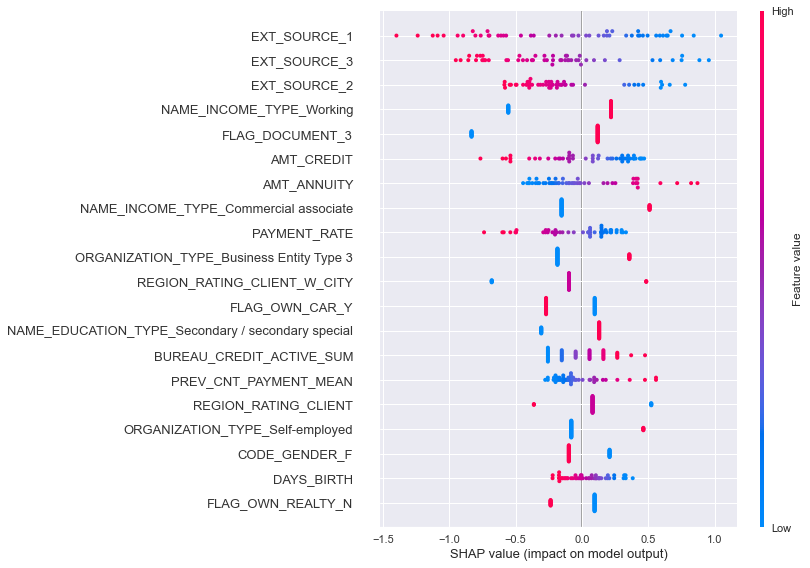

In [97]:
shap.summary_plot(shap_vals, test_sample_df, feature_names=new_features_names)

In [98]:
shap.plots.force(linear_expected, 
                shap_vals, 
                feature_names=new_features_names)

In [99]:
# For one client only
sample_id = 1000

linear_explained_sample = linear_explainer.shap_values(data_test[sample_id])

print("Sample id:", sample_id)
print("Prediction From Model: ", best_model_lr.predict(data_test[sample_id].reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value: ", linear_explainer.expected_value + shap_vals.sum())

Sample id: 1000
Prediction From Model:  0
Prediction From Adding SHAP Values to Base Value:  -45.812255571144405


We can test the feature importance for a single client:

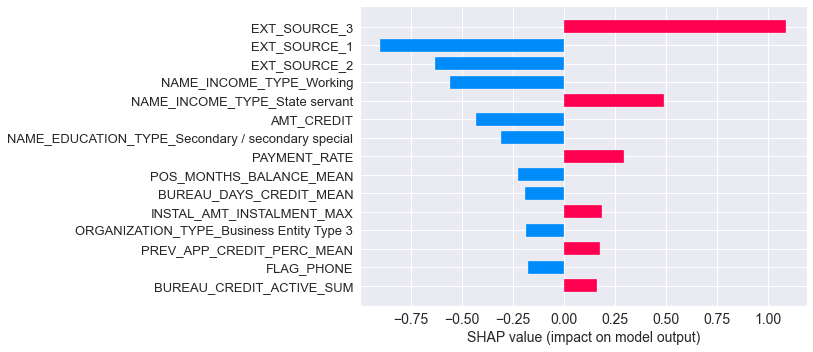

In [100]:
shap.bar_plot(linear_explained_sample,
              feature_names=new_features_names,
              max_display=15)

For this particular client, external sources are the feature that influence the most the algorithm decision. Then, the credit amount, education and organization type as well as other feature related to previous credits.

In [101]:
#shap.plots.force(linear_explainer, 
                #linear_explained_sample, 
                #feature_names=new_features_names)

In [ ]:
#_waterfall.waterfall_legacy(linear_explainer, explained_sample, data_test[sample_id], feature_names=new_features_names)

## 7. Export preprocessing and model with pickle and MLflow

Here are export of pickle files that we need for the dashoboard:
* preprocessor
* shap explainer
* list of features names (after preprocessing)
* clean dataset of all clients

In [ ]:
# Fit and export preprocessing
preprocessor.fit(data)

ColumnTransformer(transformers=[('cat_preprocessor',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')),
                                ('num_preprocesso...
                                 Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       ...
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object', l

In [ ]:
with open("pkl/scalers_preprocessing.pickle", "wb") as pickle_out:
  pickle.dump(preprocessor, pickle_out)

In [306]:
# Fit and export shap explainer
linear_explainer = shap.LinearExplainer(best_model_lr, masker=masker)

with open("pkl/linear_explainer.pickle", "wb") as pickle_out:
  pickle.dump(linear_explainer, pickle_out)

In [ ]:
# Export feature names
with open("pkl/feature_names.pickle", "wb") as pickle_out:
  pickle.dump(new_features_names, pickle_out)

In [ ]:
# Export cleaned data for histograms
with open("pkl/all_clients_data.pickle", "wb") as pickle_out:
  pickle.dump(data, pickle_out)

Now we need to save the model with MLflow for the API.

In [307]:
# Fit model
best_model_lr = LogisticRegression(penalty="l2", solver="lbfgs", C=21.544, max_iter=2000, n_jobs=-2, random_state=42)
best_model_lr.fit(data_train_smote, target_train_smote)

# If needed, you can pickle the model for futur use
#with open("pkl/best_model_lr.pickle", "wb") as pickle_out:
  #pickle.dump(best_model_lr, pickle_out)

LogisticRegression(C=21.544, max_iter=2000, n_jobs=-2, random_state=42)

In [308]:
# Make a wrapper class that will use predict proba (default is using predict)
class ProbaWrapper(mlflow.pyfunc.PythonModel):

    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        prediction = self.model.predict_proba(model_input)
        prediction_default=  prediction[0][1]*100
        return prediction_default

In [309]:
# Wrap model
wrapped_model = ProbaWrapper(best_model_lr)

In [310]:
# signature and conda-env
signature = infer_signature(data_train_smote, target_train_smote)

conda_env = {
    "channels": ["conda-forge"],
    "dependencies": ["python=3.8.8",
                    "pip",
                    {"pip": ["mlflow",
                            "cloudpickle==1.6.0",
                           "psutil==5.8.0",
                            "scikit-learn==0.24.1",
                            "typing-extensions==3.10.0.2"]}],
    "name": "mlflow-env"
    }

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [312]:
# Save model
# Should generate 'mlflow_model_pyfunc' directory
mlflow.pyfunc.save_model(
        "mlflow_model_pyfunc", 
        python_model=wrapped_model, 
        signature=signature,
        conda_env=conda_env)

Next step is deployment. To deploy in local, in a terminal: 

```cd your/directory```

Deploy MLflow API:

```mlflow models serve -m mlflow_model_pyfunc    # -h 127.0.0.1 -p 5000 to specify host and port```

Run dashboard:

```streamlit run dashboard.py```

Find the deployed dashboard+API here:

https://share.streamlit.io/florabajolet/ocr7_deploy_app/main/dashboard.py

Github repo

Analyse & modeling: https://github.com/florabajolet/OCR7_scoring

Dashboard files: https://github.com/florabajolet/OCR7_deploy_app

API files: https://github.com/florabajolet/OCR7_deploy_api